In [1]:
# import packages
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from tqdm import trange
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()
# import my files
from symae_model import SymAE
from plot_save import plot_save
from generate import generate
from plot_training import plot_training
from redatuming import redatuming
from plot_redatuming import plot_redatuming

Num GPUs Available:  2
TensorFlow Version:  2.9.1


In [2]:
# Generate the Dataset
n1 = 3 #ne
n2 = 100
nx = 15
nt = 20
assert n1 * n2 >= nx * nt
p = 2
q = 2
dropout_rate = 0
states = np.arange(n1)+1
nuisances = np.arange(n2)+1

In [3]:
data = generate(states,nuisances,nx,nt)
X = data.X
X_states = data.X_states
X_nuisances = data.X_nuisances

In [4]:
# Initialize SymAE
model = SymAE(nx,nt,p,q,dropout_rate)
model.load_weights('./checkpoints/'+datetime.now().strftime("%B%d"))
#model.load_weights('./checkpoints/'+'June16')
clear_output()

In [5]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(loss='mse',optimizer=Adam)

In [6]:
# Train the NeuralNet
M=1000
epochs=range(M)
losses=[0.0]*M
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        losses[epoch]=logs["loss"]
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
history=model.fit(X,X,epochs=M,verbose=0,callbacks=[CustomCallback()])

For epoch 999, loss is 0.131309.


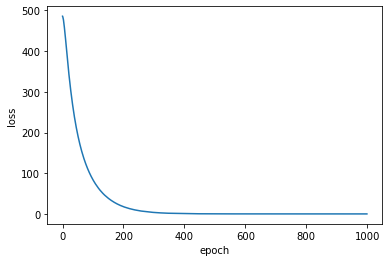

In [7]:
plt.plot(epochs,losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [8]:
# Save weights
model.save_weights('./checkpoints/'+datetime.now().strftime("%B%d"))
print("weights saved")

weights saved


1/1 [==============================] - 1s 537ms/step


Text(0.5, 1.0, 'i=0, state=1')

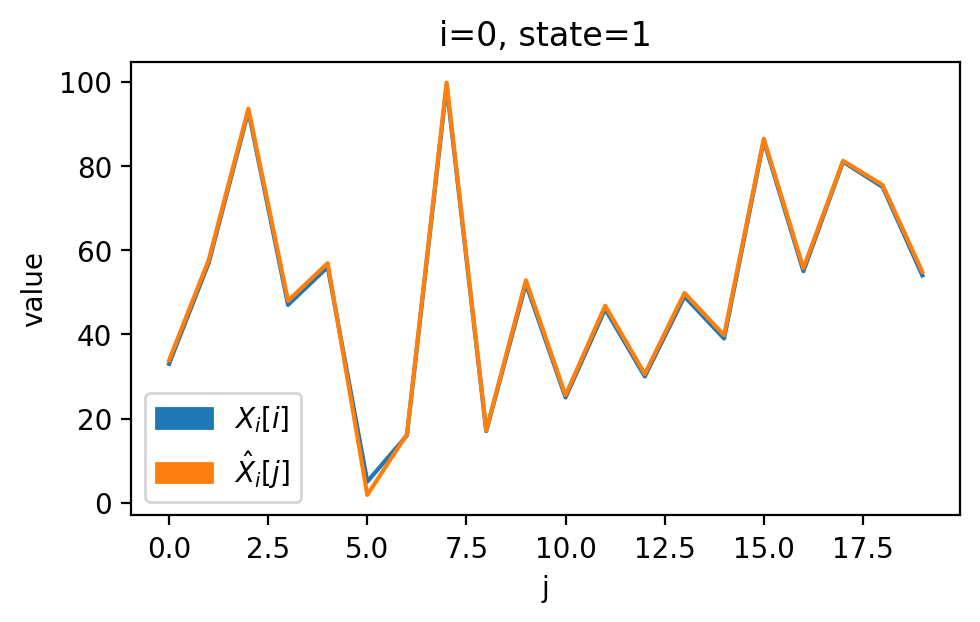

In [9]:
# Plot the result
Y = model.predict(X)
i = 0
fig = plot_training(X,Y,i)
plt.title('i=%d, state=%d'%(0,X_states[0]))

In [10]:
# Save plot
plot_save(fig,ID=-1)

Saved as plot_64.png


In [11]:
X_states[0:5]

array([1., 3., 1., 2., 1.])

In [12]:
# Redatuming
Z, Z_hat = redatuming(model,data)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


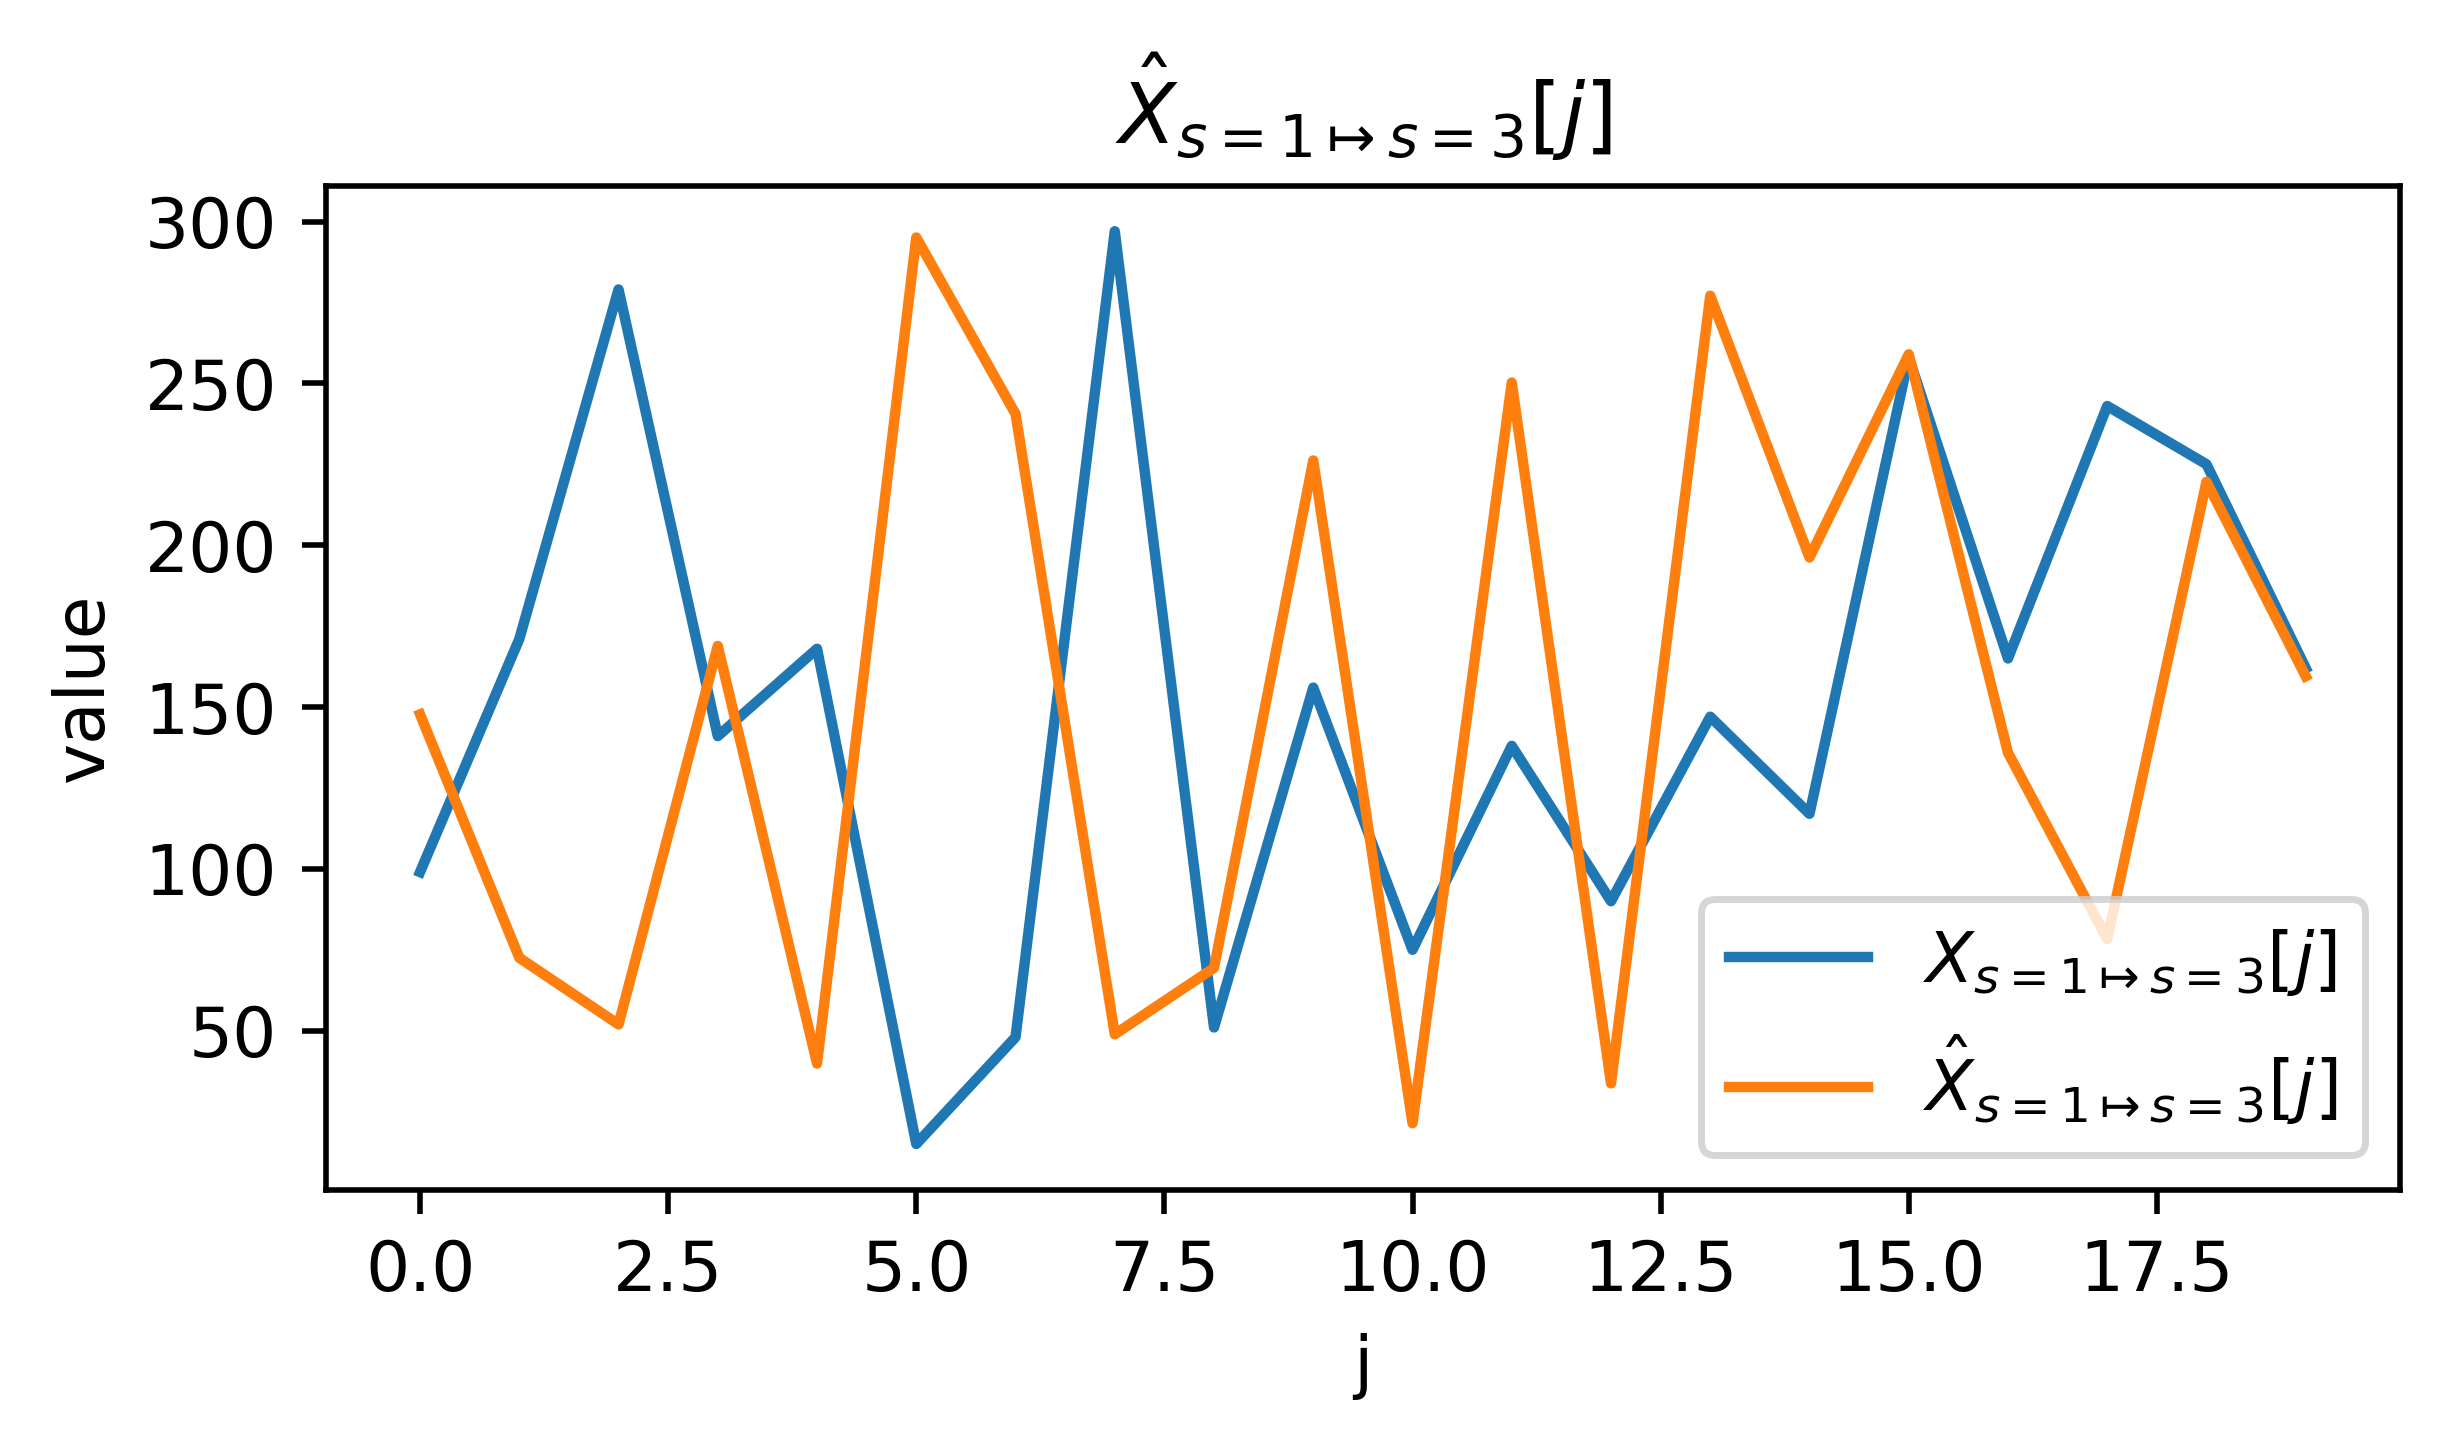

In [13]:
i = 0
i_prime = 1
fig = plot_redatuming(Z,Z_hat,X_states,i,i_prime)

In [14]:
# Save plot
plot_save(fig,ID=-1)

Saved as plot_65.png


In [15]:
def CEnc(Array_1D_len_nt,j=-1):
    return model.sym_encoder.predict(Array_1D_len_nt[np.newaxis, :, np.newaxis],verbose=0)[0,:]
def NEnc(Array_1D_len_nt,j):
    return model.nui_encoder.predict(Array_1D_len_nt[np.newaxis, :, np.newaxis],verbose=0)[0,j*q : (j+1)*q]